In [1]:
import numpy as np
from scipy.integrate import odeint
from util.plot_pairwise import pairwise

import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal

from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import AdagradRMSProp
import matplotlib.pyplot as plt
%matplotlib inline

## Adjoint ODE

Note below the input `g` is the adjoint input that comes from layers above the ODE `op`. The following code is based on the appendix code in the Neural ODE paper, and thus we retain the variable names. However, we are using manual Jacobians (as it is straightforward to obtain analytical expressions for the Jacobians in our models, and would be the case for many mechanistic models analysed in a Bayesian framework that we are aware of)  and we thus compute the VJP in the `augmented_dynamics` function. In `torchdiffeq` implementation of adjoint sensitivity, `torch.autograd.grad()` function is used, where the Jacobians are obtained through reverse-mode automatic differentiation. For an ODE model whose velocity field is a ResNet, manual Jacobians are impossible. But in practical Bayesian inference with real mechanistic models, carrying out RMAD at each solver step can be avoided by using either manual Jacobians as we have done for these models, or using symbolic expressions (and compiling such expressions to Python functions). We have added notebooks demonstrating the latter approach in this repository.

In [2]:
class GoodwinModel(object):

    def __init__(self, times, y0=None):

        if y0 is None:
            self._y0 = np.array([0,0,0], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
        self._n_states = 3
        self._n_params = 5
        self._times = times
        self._T = len(times)
            
    def solve(self, parameters):
        return self._solve(parameters, None, None, False)

    def solve_with_sensitivities(self, parameters, yt, g):
        return self._solve(parameters, yt, g, True)

    def _solve(self, parameters, yt, g, sensitivities):
        
        a1, a2, alpha, k1, k2 = [float(x) for x in parameters]
        
        def r(y, t, p):
            
            X1, X2, X3=y
            dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
            dX2_dt = (k1*X1) - (alpha*X2);
            dX3_dt = (k2*X2) - (alpha*X3);
            
            return dX1_dt,dX2_dt,dX3_dt

        if sensitivities:
            def jac_x(y):
                X1, X2, X3 = y
                ret = np.empty((self._n_states, self._n_states))
                ret[0, 0] = -alpha
                ret[0, 1] = 0
                ret[0, 2] = -(a1*a2*10*(X3**9))/( (1 + a2*(X3**10))**2 )
                
                ret[1, 0] = k1
                ret[1, 1] = -alpha
                ret[1, 2] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = k2
                ret[2, 2] = -alpha
                return ret

            def jac_p(y):
                X1, X2, X3 = y
                ret = np.empty((self._n_states, self._n_params))
                ret[0, 0] = 1/(1+a2*(X3**10))
                ret[0, 1] = -(a1*(X3**10))/( (1 + a2*(X3**10))**2 )
                ret[0, 2] = -X1
                ret[0, 3] = 0
                ret[0, 4] = 0
                
                ret[1, 0] = 0
                ret[1, 1] = 0
                ret[1, 2] = -X2
                ret[1, 3] = X1
                ret[1, 4] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = 0
                ret[2, 2] = -X3
                ret[2, 3] = 0
                ret[2, 4] = X2               
                return ret

            def augmented_dynamics(aug_state, t, p):
                y_t, neg_adj_t, _,_ = unpack(aug_state)
                dy_dt_t = r(y_t, t, p)
                dfdp_t = jac_p(y_t)
                jac_t = jac_x(y_t)
                vjp_y = np.dot(-neg_adj_t, jac_t)
                vjp_th = np.dot(-neg_adj_t, dfdp_t)
                vjp_t = np.dot(-neg_adj_t, dy_dt_t)
                
                return np.hstack((dy_dt_t, vjp_y, vjp_t, vjp_th))
            
            # The following section is largely based on the Neural ODE paper
            # and so we have retained the variable names as much as possible
            T, D = np.shape(yt)
            
            def unpack(x):
                return x[ 0 : D], x[D : 2*D], x[2*D], x[2*D + 1:]
            
            vjp_y = g[-1, :]
            vjp_t0 = 0
            time_vjp_list = []
            vjp_params = np.zeros(np.size(parameters))

            for i in range(T - 1, 0, -1):

                # Compute effect of moving measurement time.
                vjp_cur_t = np.dot(r(yt[i, :], self._times[i], parameters), g[i, :])
                time_vjp_list.append(vjp_cur_t)
                vjp_t0 = vjp_t0 - vjp_cur_t

                # Run augmented system backwards to the previous observation.
                aug_y0 = np.hstack((yt[i, :], vjp_y, vjp_t0, vjp_params))
                #print(aug_y0.shape)
                aug_ans = odeint(augmented_dynamics, aug_y0,
                                 np.array([self._times[i], self._times[i - 1]]), 
                                 (parameters,), rtol=1e-5, atol=1e-6)
                _, vjp_y, vjp_t0, vjp_params = unpack(aug_ans[1])

                # Add gradient from current output.
                vjp_y = vjp_y + g[i - 1, :]

            time_vjp_list.append(vjp_t0)
            vjp_times = np.hstack(time_vjp_list)[::-1]
            
            return vjp_params
            
        else:
            x = odeint(r, self._y0, self._times, (parameters,), rtol=1e-5, atol=1e-6)
            return x


## Simulated data with Gaussian noise

Text(0, 0.5, 'Concentration')

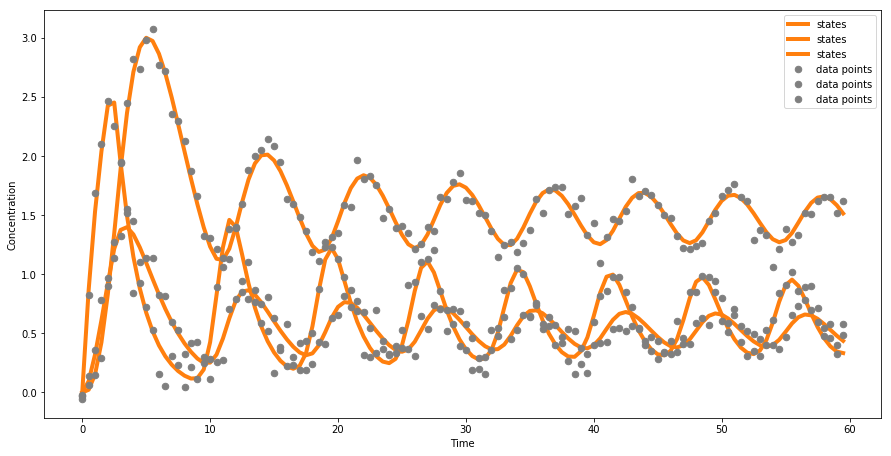

In [3]:
times = np.arange(0,60, 0.5)
gw_ode_model = GoodwinModel(times);
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=gw_ode_model.solve(real_params)
np.random.seed(121) 
Y=sol+np.random.randn(120,3)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='states')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')

## Custom ODE op with VJP from adjoint

In this case the custom `op` is different, from the forawrd sensitivity approach, as the VJP is directly obtained through the adjoint system above. Thus, interestingly there is ODE solves in both forward and backward method unlike, forward sensitivity, which renders this approach slower in comparison when large number of measurements are considered or the models have handful of parameters. If $d<50$ or $T>100$ better to try the forward sensitivity. Note that here we pass the adjoint (the `grad_output`) that is then used in the repeated ODE solution (in backward time).

In [4]:
class ODEop(Function):  
    @staticmethod
    def forward(ctx, params): 
        numpy_params = params.detach().numpy()
        
        states = gw_ode_model.solve(numpy_params)
        ctx.save_for_backward(params, torch.as_tensor(states, dtype=params.dtype))
        return params.new(states)

    @staticmethod
    def backward(ctx, grad_output):
        g = grad_output.detach().numpy()
        numpy_p = ctx.saved_tensors[0].detach().numpy()
        numpy_states = ctx.saved_tensors[1].detach().numpy()
        vjp = gw_ode_model.solve_with_sensitivities(numpy_p, numpy_states, g)     
        return grad_output.new(vjp)

## Generative model

In [5]:
y_torch = torch.tensor(Y,dtype=torch.float)

In [6]:
class GoodwinGenModel(PyroModule):
    def __init__(self):        
        super(GoodwinGenModel, self).__init__()
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data):         
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = ODEop.apply(self.ode_params)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.Normal(states, scale).to_event(1),
                        obs=data)
            return states

In [7]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
model = GoodwinGenModel()
guide = AutoMultivariateNormal(model)
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [8]:
def train():
    loss_trace = []
    for j in range(30000):
        # calculate the loss and take a gradient step
        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace


In [9]:
%%time
loss_graph = train()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

[iteration 0001] loss: 514.3626
[iteration 0501] loss: 10.5392
[iteration 1001] loss: -173.1351
[iteration 1501] loss: -234.2234
[iteration 2001] loss: -264.2250
[iteration 2501] loss: -276.6130
[iteration 3001] loss: -286.8385
[iteration 3501] loss: -283.8221
[iteration 4001] loss: -290.8197
[iteration 4501] loss: -290.7043
[iteration 5001] loss: -293.8057
[iteration 5501] loss: -292.3165
[iteration 6001] loss: -294.5989
[iteration 6501] loss: -294.3917
[iteration 7001] loss: -294.2468
[iteration 7501] loss: -295.7906
[iteration 8001] loss: -295.6771
[iteration 8501] loss: -297.9620
[iteration 9001] loss: -296.6969
[iteration 9501] loss: -296.0333
[iteration 10001] loss: -297.2647
[iteration 10501] loss: -297.5613
[iteration 11001] loss: -297.5618
[iteration 11501] loss: -298.1718
[iteration 12001] loss: -297.9669
[iteration 12501] loss: -297.1872
[iteration 13001] loss: -298.3107
[iteration 13501] loss: -298.6348
[iteration 14001] loss: -298.3707
[iteration 14501] loss: -298.4778
[it

In [10]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("ode_params", "scale", "obs", "_RETURN"))
vb_ppc_samples = predictive(y_torch)

In [11]:
vb_params=np.concatenate((vb_ppc_samples['ode_params'].detach().numpy().reshape((1000,5))
                          ,vb_ppc_samples['scale'].detach().numpy()),axis=1)
np.savetxt('gw_vb_adj.txt', vb_params)

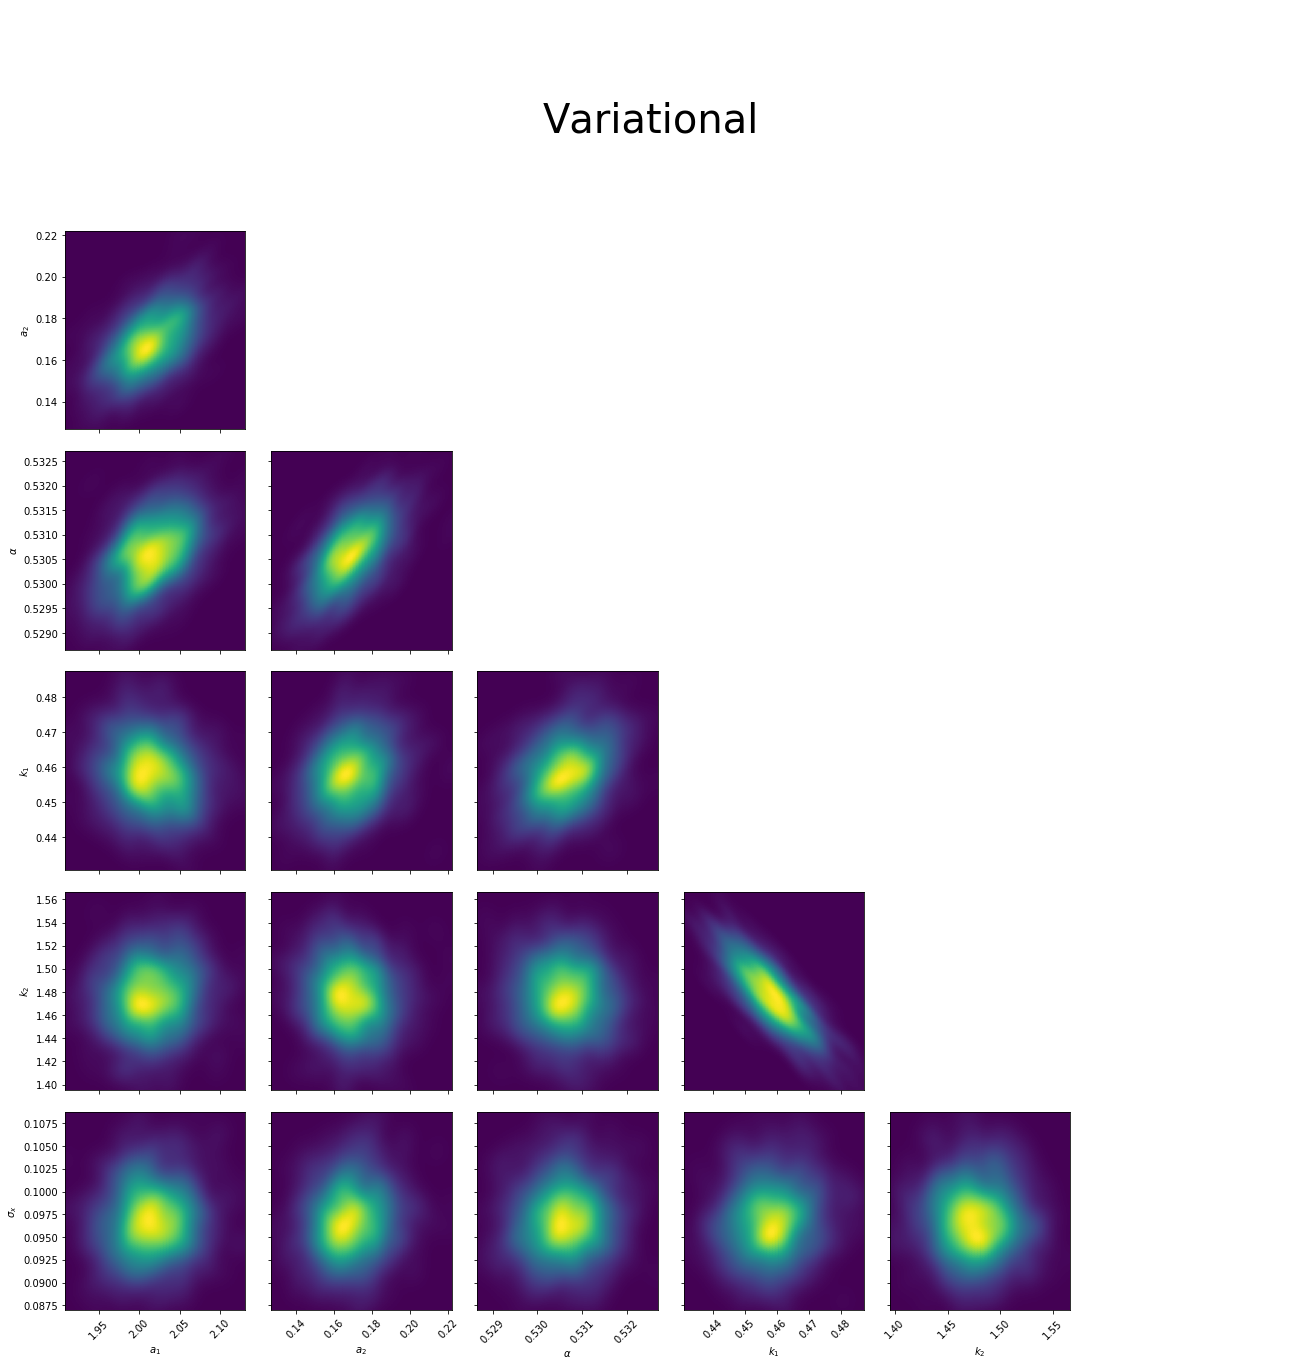

In [12]:
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$", r"$\sigma_x$"]

pairwise(vb_params, 'Variational', param_names);


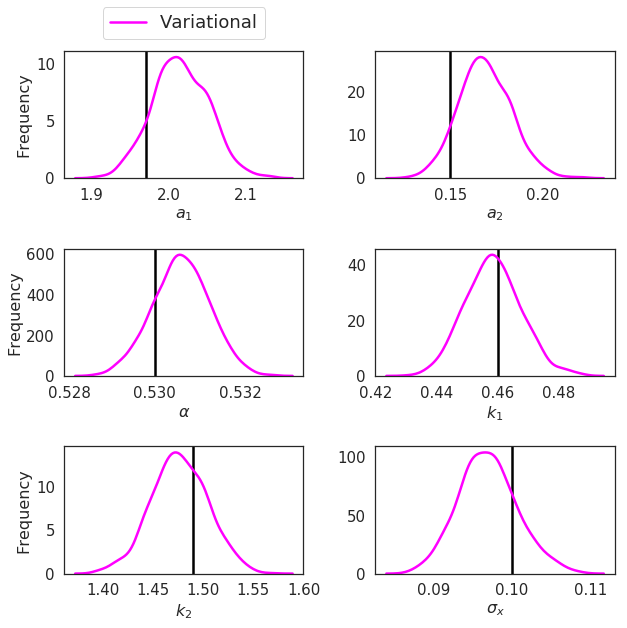

In [14]:
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,9),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")
real_params.append(0.1)
for i, p in enumerate(param_names):
        
        plt.subplot(3, 2, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()